# Runs through and finds the most conserved (rbfox2) motifs
- comments out some of these blocks since they're a part of scoring/file creation which takes awhile. Once the files are made, no need to run through again.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import pybedtools
import pyBigWig
import os
from scipy import stats
from tqdm import tnrange, tqdm_notebook
from collections import defaultdict

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/motif_coords/'

In [3]:
phastcons_file = '/projects/ps-yeolab3/bay001/annotations/conservation/hg19.phastCons46way.placental.wigFix.bw'
motifs_file = os.path.join(input_dir, 'GCATG_RBFOX_MOTIF_POSITIONS_ALL.annotated') # these were annotated in a strand-specific manner, so positions on the opposite strand of a gene will mostly be labeled intergenic (unless there is an overlapping antisense thing going on)

# Use a modified function to get conservation scores from bigwig file

In [4]:
class Density:
    def values(self, chrom, start, end, strand):
        return 0
    
class Phastcon(Density):

    def __init__(self, phastcon, name=None):
        try:
            self.phastcon = pyBigWig.open(phastcon)
            self.name = name if name is not None else os.path.basename(phastcon)
        except Exception as e:
            print("couldn't open the bigwig file!")
            print(e)

    def values(self, chrom, start, end, strand):
        """
        Parameters
        ----------
        chrom : basestring
            (eg. chr1)
        start : int
            0-based start (first position in chromosome is 0)
        end : int
            1-based end (last position is not included)
        strand : str
            either '+' or '-'
        Returns
        -------
        densites : list
            values corresponding to density over specified positions.
        """

        try:
            if strand == "+":
                return self.phastcon.values(chrom, start, end)
            elif strand == "-":
                return list(reversed(self.phastcon.values(chrom, start, end)))
            else:
                print("Strand neither + or -")
                return 1
        except RuntimeError:
            # usually occurs when no chromosome exists in the bigwig file
            return [np.NaN] * abs(start - end)
        
    def avg_cons(self, chrom, start, end, strand):
        
        values = pd.Series(self.values(chrom, start, end, strand))
        values.fillna(0, inplace=True)
        return values.mean()
        

In [5]:
cd = Phastcon(phastcons_file)

In [6]:
cd.values('chrY',28438600,28438605,'-') # 'chr10:180750-180776'chrY 	28438600 	28438605

[0.9309999942779541,
 0.9340000152587891,
 0.9350000023841858,
 0.9350000023841858,
 0.9330000281333923]

# Motifs file contains every position where I found either GCATG or its reverse complement (CATGC). 
- Let's try to use annotator to select correctly-stranded regions. If we cannot identify a position on its specified strand, can we assume that it's not really a true motif?

### Let's just test to make sure we can definitively say the above assumption is true.

# Let's select motifs found on genic (annotated) regions. 

In [7]:
genic_scores = pd.read_csv(os.path.join(output_dir, 'GCATG_RBFOX_MOTIF_POSITIONS_ALL_GENIC.phastCons46way.txt'), sep='\t', index_col=0)
genic_scores.head()

,scores
chr10:91096-91101:+,0.1272
chr10:91842-91847:+,0.0316
chr10:92302-92307:+,0.0624
chr10:92729-92734:+,0.0274
chr10:180760-180765:+,0.0128


1697815


,index,scores
0,chr10:91096-91101:+,0.1272
1,chr10:91842-91847:+,0.0316
2,chr10:92302-92307:+,0.0624
3,chr10:92729-92734:+,0.0274
4,chr10:180760-180765:+,0.0128


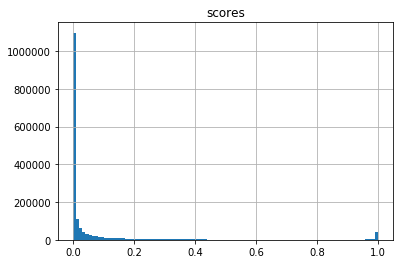

In [8]:
print(genic_scores.shape[0])
genic_scores.hist(bins=100)
genic_scores.reset_index(inplace=True)
genic_scores.head()

In [9]:
# select highly conserved motifs
genic_scores = genic_scores[genic_scores['scores']>=0.9]
print(genic_scores.shape[0])

56326


In [10]:
# format to BED:
genic_scores['chrom'] = genic_scores['index'].apply(lambda x: x.split(':')[0])
genic_scores['start'] = genic_scores['index'].apply(lambda x: int(x.split(':')[1].split('-')[0]))
genic_scores['end'] = genic_scores['index'].apply(lambda x: int(x.split(':')[1].split('-')[1]))
genic_scores['strand'] = genic_scores['index'].apply(lambda x: x.split(':')[2])
genic_scores = genic_scores[['chrom','start','end','index','scores','strand']]
genic_scores.head()

,chrom,start,end,index,scores,strand
74,chr10,264199,264204,chr10:264199-264204:+,0.998,+
91,chr10,282841,282846,chr10:282841-282846:+,1.000,+
99,chr10,294441,294446,chr10:294441-294446:+,1.000,+
104,chr10,299431,299436,chr10:299431-299436:+,1.000,+
105,chr10,300204,300209,chr10:300204-300209:+,1.000,+


In [11]:
genic_scores.tail()

,chrom,start,end,index,scores,strand
1697620,chrY,27859521,27859526,chrY:27859521-27859526:-,0.9138,-
1697683,chrY,28344541,28344546,chrY:28344541-28344546:-,1.0000,-
1697708,chrY,28438600,28438605,chrY:28438600-28438605:-,0.9336,-
1697764,chrY,28499045,28499050,chrY:28499045-28499050:-,0.9640,-
1697810,chrY,59358567,59358572,chrY:59358567-59358572:-,0.9702,-


In [12]:
genic_scores.to_csv(os.path.join(output_dir, 'GCATG_RBFOX_MOTIF_POSITIONS_ALL_GENIC.phastCons46way.conserved.bed'), sep='\t', index=False, header=False)